In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML

import io
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


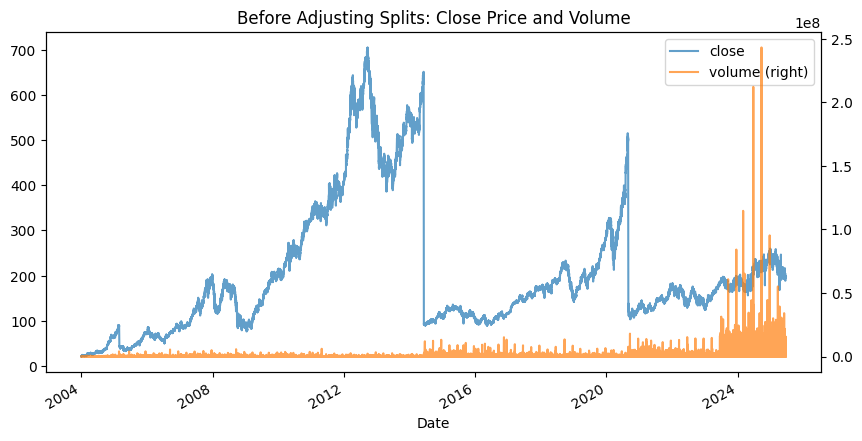

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


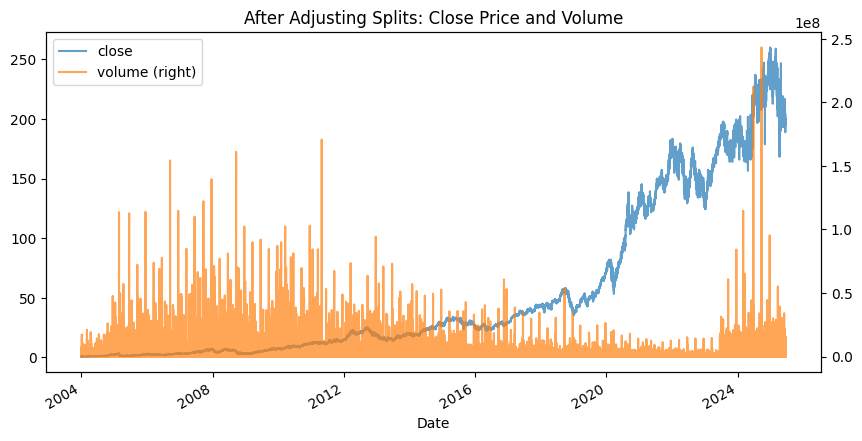

[main] Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 11:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 200
n_jobs = 1

base_csv = params.base_csv

df_raw = trades.process_splits(
    folder                   = params.stocks_folder,
    ticker                   = ticker,
    bidasktoclose_spread     = params.bidasktoclose_spread
)

# Once‐only minute grid build and interpolation
print(f"[main] Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df                    = df_raw,
    regular_start_shifted = params.regular_start_shifted,
    regular_start         = params.regular_start,
    regular_end           = params.regular_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [5]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back,
        60
    ))
    regular_start_shifted = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back*2,
        60
    ))

    # A) dynamic reference profit
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # — use all trading days for the daily-P&L average —
    num_days      = trades.count_trading_days(df, params.regular_start, params.regular_end)
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days if num_days else 0.0

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")

    # F) cleanup & return
    del simulation, per_day_stats, trade_days_stats, daily_returns
    gc.collect()

    return avg_daily_pnl


In [6]:
def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", [30,60,90,120,150,180]),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 0.7),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 0.9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 0.7),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 0.7),
        "smooth_win_sig"          : trial.suggest_int("smooth_win_sig", 1, 60),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.1, 0.7),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.01, 0.5),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.01, 0.5),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.5),
    }

    print('---------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-08-03 15:39:30,581] A new study created in RDB with name: no-name-b2d85ecb-afae-44a6-8d27-0351b6bfffb1


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2316.73
→ Avg daily return (all days)          : $0.4290
→ Total trades                          : 6469
→ Avg return per trade                  : $0.3581



[I 2025-08-03 15:42:26,670] Trial 0 finished with value: 0.4290248148148148 and parameters: {'look_back': 120, 'min_prof_thr': 0.40997870304841233, 'max_down_prop': 0.39466387100749534, 'gain_tightening_factor': 0.5099815975974011, 'merging_retracement_thr': 0.6953766793807853, 'merging_time_gap_thr': 0.34866995565441977, 'smooth_win_sig': 4, 'pre_entry_decay': 0.4601800969803843, 'short_penalty': 0.23085592375999894, 'trailing_stop_thresh': 0.031373688953950526, 'buy_threshold': 0.25932588619549013}. Best is trial 0 with value: 0.4290248148148148.


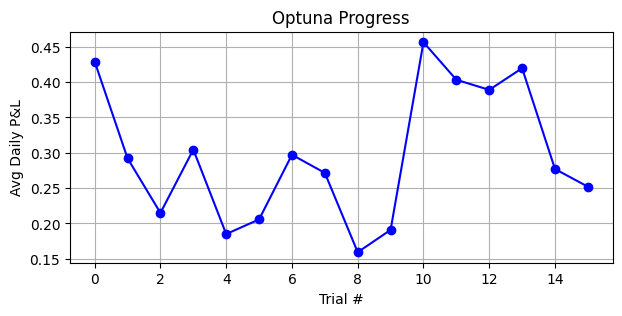

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1577.38
→ Avg daily return (all days)          : $0.2921
→ Total trades                          : 3104
→ Avg return per trade                  : $0.5082



[I 2025-08-03 15:46:00,174] Trial 1 finished with value: 0.2921074074074074 and parameters: {'look_back': 180, 'min_prof_thr': 0.6511402370282574, 'max_down_prop': 0.4161688396951857, 'gain_tightening_factor': 0.46963562913070156, 'merging_retracement_thr': 0.48150783020308907, 'merging_time_gap_thr': 0.6239347411320346, 'smooth_win_sig': 16, 'pre_entry_decay': 0.3504329488381114, 'short_penalty': 0.06414616823256432, 'trailing_stop_thresh': 0.2607069573549767, 'buy_threshold': 0.39259636014465693}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1159.93
→ Avg daily return (all days)          : $0.2148
→ Total trades                          : 3239
→ Avg return per trade                  : $0.3581



[I 2025-08-03 15:48:41,499] Trial 2 finished with value: 0.21480129629629632 and parameters: {'look_back': 90, 'min_prof_thr': 0.3146318962173112, 'max_down_prop': 0.6205990795343619, 'gain_tightening_factor': 0.18997902042987969, 'merging_retracement_thr': 0.45879308748710135, 'merging_time_gap_thr': 0.26172569642232724, 'smooth_win_sig': 12, 'pre_entry_decay': 0.6830172485220558, 'short_penalty': 0.2677609986615819, 'trailing_stop_thresh': 0.4776331718293127, 'buy_threshold': 0.26543087239971513}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1644.40
→ Avg daily return (all days)          : $0.3045
→ Total trades                          : 2262
→ Avg return per trade                  : $0.7270



[I 2025-08-03 15:51:27,076] Trial 3 finished with value: 0.304517962962963 and parameters: {'look_back': 120, 'min_prof_thr': 0.6788225983375265, 'max_down_prop': 0.7844079948375006, 'gain_tightening_factor': 0.14174469288468894, 'merging_retracement_thr': 0.29949838345613483, 'merging_time_gap_thr': 0.21416010154388299, 'smooth_win_sig': 27, 'pre_entry_decay': 0.4935312834792829, 'short_penalty': 0.21216789604388142, 'trailing_stop_thresh': 0.2264792742534171, 'buy_threshold': 0.4416788526665953}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $998.59
→ Avg daily return (all days)          : $0.1849
→ Total trades                          : 4374
→ Avg return per trade                  : $0.2283



[I 2025-08-03 15:54:22,408] Trial 4 finished with value: 0.18492425925925923 and parameters: {'look_back': 120, 'min_prof_thr': 0.11354560174410176, 'max_down_prop': 0.8067504159590253, 'gain_tightening_factor': 0.7848864716031113, 'merging_retracement_thr': 0.1774227413651236, 'merging_time_gap_thr': 0.6362270051353944, 'smooth_win_sig': 17, 'pre_entry_decay': 0.39986023093996315, 'short_penalty': 0.041876328182240255, 'trailing_stop_thresh': 0.41506467011440046, 'buy_threshold': 0.23454217246486186}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1110.31
→ Avg daily return (all days)          : $0.2056
→ Total trades                          : 4218
→ Avg return per trade                  : $0.2632



[I 2025-08-03 15:57:12,211] Trial 5 finished with value: 0.20561277777777773 and parameters: {'look_back': 120, 'min_prof_thr': 0.18535998444481933, 'max_down_prop': 0.2248013790422168, 'gain_tightening_factor': 0.29811343509039717, 'merging_retracement_thr': 0.4976601517833762, 'merging_time_gap_thr': 0.27186371734072257, 'smooth_win_sig': 11, 'pre_entry_decay': 0.5097333796288176, 'short_penalty': 0.14304657283418173, 'trailing_stop_thresh': 0.39488942449592357, 'buy_threshold': 0.24987039010765277}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1604.55
→ Avg daily return (all days)          : $0.2971
→ Total trades                          : 2214
→ Avg return per trade                  : $0.7247



[I 2025-08-03 16:00:33,802] Trial 6 finished with value: 0.29713925925925927 and parameters: {'look_back': 180, 'min_prof_thr': 0.5324752826032132, 'max_down_prop': 0.7888858621233028, 'gain_tightening_factor': 0.585222266041005, 'merging_retracement_thr': 0.6552697974452942, 'merging_time_gap_thr': 0.3855172235234371, 'smooth_win_sig': 54, 'pre_entry_decay': 0.46321372611671785, 'short_penalty': 0.22085747756710364, 'trailing_stop_thresh': 0.024045018747519575, 'buy_threshold': 0.4081903431186338}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1465.95
→ Avg daily return (all days)          : $0.2715
→ Total trades                          : 3061
→ Avg return per trade                  : $0.4789



[I 2025-08-03 16:03:33,395] Trial 7 finished with value: 0.27147203703703704 and parameters: {'look_back': 120, 'min_prof_thr': 0.3647758301248679, 'max_down_prop': 0.8774641523425716, 'gain_tightening_factor': 0.4443821938404179, 'merging_retracement_thr': 0.17391949139206356, 'merging_time_gap_thr': 0.6224228699097575, 'smooth_win_sig': 37, 'pre_entry_decay': 0.3192381036659975, 'short_penalty': 0.2629160703509932, 'trailing_stop_thresh': 0.16476241466339744, 'buy_threshold': 0.2939941057480303}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $859.65
→ Avg daily return (all days)          : $0.1592
→ Total trades                          : 3506
→ Avg return per trade                  : $0.2452



[I 2025-08-03 16:05:43,116] Trial 8 finished with value: 0.15919407407407407 and parameters: {'look_back': 30, 'min_prof_thr': 0.43384385338794185, 'max_down_prop': 0.32040662371085055, 'gain_tightening_factor': 0.40928025902004905, 'merging_retracement_thr': 0.6753552094292032, 'merging_time_gap_thr': 0.5294722888887007, 'smooth_win_sig': 40, 'pre_entry_decay': 0.3876375041857357, 'short_penalty': 0.03872004809142138, 'trailing_stop_thresh': 0.4628848526751396, 'buy_threshold': 0.17197883356498028}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1030.20
→ Avg daily return (all days)          : $0.1908
→ Total trades                          : 4964
→ Avg return per trade                  : $0.2075



[I 2025-08-03 16:08:38,791] Trial 9 finished with value: 0.19077833333333333 and parameters: {'look_back': 150, 'min_prof_thr': 0.36203836898934316, 'max_down_prop': 0.23172515129286478, 'gain_tightening_factor': 0.8773541588768718, 'merging_retracement_thr': 0.5555125695895115, 'merging_time_gap_thr': 0.37122313355303294, 'smooth_win_sig': 14, 'pre_entry_decay': 0.1285330720580779, 'short_penalty': 0.2440759487944837, 'trailing_stop_thresh': 0.3405741824476989, 'buy_threshold': 0.1266410851392183}. Best is trial 0 with value: 0.4290248148148148.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2464.89
→ Avg daily return (all days)          : $0.4565
→ Total trades                          : 8726
→ Avg return per trade                  : $0.2825



[I 2025-08-03 16:10:55,638] Trial 10 finished with value: 0.4564614814814815 and parameters: {'look_back': 60, 'min_prof_thr': 0.5245530049699154, 'max_down_prop': 0.5645593241619242, 'gain_tightening_factor': 0.6326121192236164, 'merging_retracement_thr': 0.30672431870380784, 'merging_time_gap_thr': 0.15290074641781903, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6642433129579295, 'short_penalty': 0.42453268154277113, 'trailing_stop_thresh': 0.03901791288352577, 'buy_threshold': 0.07789786548565797}. Best is trial 10 with value: 0.4564614814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2177.98
→ Avg daily return (all days)          : $0.4033
→ Total trades                          : 8360
→ Avg return per trade                  : $0.2605



[I 2025-08-03 16:13:12,136] Trial 11 finished with value: 0.4033292592592593 and parameters: {'look_back': 60, 'min_prof_thr': 0.5293152910547981, 'max_down_prop': 0.5599965244824442, 'gain_tightening_factor': 0.6469056949553073, 'merging_retracement_thr': 0.3162989756425477, 'merging_time_gap_thr': 0.10392925348771466, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6865461461748652, 'short_penalty': 0.4365589087634588, 'trailing_stop_thresh': 0.01056146581370018, 'buy_threshold': 0.09102534325262812}. Best is trial 10 with value: 0.4564614814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2100.62
→ Avg daily return (all days)          : $0.3890
→ Total trades                          : 8113
→ Avg return per trade                  : $0.2589



[I 2025-08-03 16:15:29,428] Trial 12 finished with value: 0.3890038888888889 and parameters: {'look_back': 60, 'min_prof_thr': 0.4961517036164954, 'max_down_prop': 0.4503527451352773, 'gain_tightening_factor': 0.6686739089325802, 'merging_retracement_thr': 0.33870700819387434, 'merging_time_gap_thr': 0.11432644373521217, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5919005185868471, 'short_penalty': 0.41713419980963384, 'trailing_stop_thresh': 0.10822587453138743, 'buy_threshold': 0.05828430661813305}. Best is trial 10 with value: 0.4564614814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2266.31
→ Avg daily return (all days)          : $0.4197
→ Total trades                          : 5408
→ Avg return per trade                  : $0.4191



[I 2025-08-03 16:17:46,023] Trial 13 finished with value: 0.4196862962962963 and parameters: {'look_back': 60, 'min_prof_thr': 0.2608076249109025, 'max_down_prop': 0.6481960965649417, 'gain_tightening_factor': 0.5666678536398357, 'merging_retracement_thr': 0.2435630415595656, 'merging_time_gap_thr': 0.4749834382142921, 'smooth_win_sig': 1, 'pre_entry_decay': 0.23595770432999447, 'short_penalty': 0.35406476437836526, 'trailing_stop_thresh': 0.08991746729847375, 'buy_threshold': 0.3615582727335686}. Best is trial 10 with value: 0.4564614814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1495.61
→ Avg daily return (all days)          : $0.2770
→ Total trades                          : 3661
→ Avg return per trade                  : $0.4085



[I 2025-08-03 16:20:14,643] Trial 14 finished with value: 0.276965 and parameters: {'look_back': 90, 'min_prof_thr': 0.5786965051610298, 'max_down_prop': 0.362186578775358, 'gain_tightening_factor': 0.7293757878851805, 'merging_retracement_thr': 0.10498333995644515, 'merging_time_gap_thr': 0.19445523515187194, 'smooth_win_sig': 28, 'pre_entry_decay': 0.5879637956280314, 'short_penalty': 0.48920092859155095, 'trailing_stop_thresh': 0.10041124283173042, 'buy_threshold': 0.17625426655161955}. Best is trial 10 with value: 0.4564614814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1360.59
→ Avg daily return (all days)          : $0.2520
→ Total trades                          : 2317
→ Avg return per trade                  : $0.5872



[I 2025-08-03 16:22:17,877] Trial 15 finished with value: 0.25196166666666664 and parameters: {'look_back': 30, 'min_prof_thr': 0.4514752674791547, 'max_down_prop': 0.5196635422282277, 'gain_tightening_factor': 0.3338671792189287, 'merging_retracement_thr': 0.3956591654049902, 'merging_time_gap_thr': 0.3197102863982271, 'smooth_win_sig': 60, 'pre_entry_decay': 0.5819282964450043, 'short_penalty': 0.3399001196509695, 'trailing_stop_thresh': 0.1944876288343641, 'buy_threshold': 0.33044984882283884}. Best is trial 10 with value: 0.4564614814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial=True,
)

# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars.json"
file_path  = os.path.join(params.optuna_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
